In [26]:
from matplotlib import *
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
import networkx as nx
import geopandas as gpd

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from scipy.stats import linregress, spearmanr, chi2


### download the shapefile 
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html   
choose the States map

In [2]:
us = gpd.read_file('Origin_and_Destination_Survey_DB1BCoupon_2014_1/us-state-boundaries.geojson')

In [3]:
us.head()

,gid,arealand,division,intptlat,name,objectid,areawater,intptlon,oid,funcstat,...,state,statens,centlat,basename,mtfcc,region,lsadc,geoid,geo_point_2d,geometry
0,16,278176477,0,18.217648,Puerto Rico,50,628200285,-66.410799,303146031,A,...,72,01779808,18.216472,Puerto Rico,G4000,9,00,72,"{'lon': -66.4146425123, 'lat': 18.2157325628}","MULTIPOLYGON (((-67.20794 18.44228, -67.21713 ..."
1,23,472276664,0,14.936784,Commonwealth of the Northern Mariana Islands,36,349301029,145.601021,-1625647860,A,...,69,01779809,16.797438,Commonwealth of the Northern Mariana Islands,G4000,9,00,69,"{'lon': 145.595809651, 'lat': 16.8164771029}","MULTIPOLYGON (((145.57260 15.12502, 145.64831 ..."
2,31,1627312771,7,34.895526,Arkansas,44,-1334552525,-92.444626,266078934,A,...,05,00068085,34.894021,Arkansas,G4000,3,00,05,"{'lon': -92.4393557454, 'lat': 34.899695632}","POLYGON ((-94.55218 36.10224, -94.58620 36.299..."
3,35,2136109036,5,38.647285,West Virginia,1,489848791,-80.618327,-1929409300,A,...,54,01779805,38.641186,West Virginia,G4000,3,00,54,"{'lon': -80.6137013299, 'lat': 38.6425782646}","POLYGON ((-81.74725 39.09538, -81.74385 39.102..."
4,40,-1616974352,1,41.597419,Rhode Island,6,1323457457,-71.527272,-1861167639,A,...,44,01219835,41.594025,Rhode Island,G4000,1,00,44,"{'lon': -71.524812176, 'lat': 41.5946933039}","MULTIPOLYGON (((-71.78970 41.72456, -71.79788 ..."


download the US airports IATA codes at https://davidmegginson.github.io/ourairports-data/   
choose airports.csv

In [4]:
cod = pd.read_csv('Origin_and_Destination_Survey_DB1BCoupon_2014_1/airports.csv', sep=',')
cod = cod[cod['iso_country']=='US']
cod = cod[pd.isna(cod.iata_code)==False]
codes = dict(zip(cod['iata_code'],cod['municipality']))
#cod.drop_duplicates('Airport Name', keep='first')
cod['pos'] = cod[['longitude_deg', 'latitude_deg']].values.tolist()
pos = dict(zip(cod['municipality'],cod['pos']))

In [23]:
pos['Clear Lake']

[-93.331299, 43.157799]

### download the origin-destination air travels from    
https://transtats.bts.gov/PREZIP/Origin_and_Destination_Survey_DB1BCoupon_{year}_{quarter}.zip  
replace {year} and {quarter} in the URL

In [5]:
df = pd.read_csv('Origin_and_Destination_Survey_DB1BCoupon_2014_1/Origin_and_Destination_Survey_DB1BCoupon_2014_1.csv',)
df = df[['Year','Origin','OriginCountry','OriginState','Dest','DestCountry','DestState','Passengers','Distance']]
df = df[(df.Origin.isin(codes))&(df.Dest.isin(codes))]

In [6]:
df['OrigCity'] = df['Origin'].apply(lambda x: codes[x])
df['DestCity'] = df['Dest'].apply(lambda x: codes[x])

In [7]:
df.head()

,Year,Origin,OriginCountry,OriginState,Dest,DestCountry,DestState,Passengers,Distance,OrigCity,DestCity
0,2014,MSP,US,MN,MCI,US,MO,1.0,393.0,Minneapolis,Kansas City
1,2014,IAH,US,TX,BWI,US,MD,1.0,1235.0,Houston,Baltimore
2,2014,ORD,US,IL,SEA,US,WA,1.0,1721.0,Chicago,Seattle
3,2014,ATL,US,GA,BDL,US,CT,1.0,859.0,Atlanta,Hartford
4,2014,BOS,US,MA,DCA,US,VA,1.0,399.0,Boston,Washington


In [8]:
entr = df.groupby(['OrigCity','DestCity'])['Passengers'].sum()


In [9]:
airports = set(df.OrigCity.unique()).union(set(df.DestCity.unique()))

### define fraction of passengers from origin traveling to each destination

In [15]:
OD_matrix = entr.to_frame().reset_index()
#OD_matrix.to_csv('od_matrix_airports.csv',index=False)

In [36]:
OD_matrix = pd.read_csv('od_matrix_airports.csv')

In [37]:
OD_matrix = entr.to_frame().reset_index()
tot_outflows = OD_matrix.groupby(by='OrigCity', axis=0)[['Passengers']].sum().fillna(0)
OD_matrix = OD_matrix.merge(tot_outflows, left_on='OrigCity', right_on='OrigCity').rename(columns={'Passengers_x': 'Passengers','Passengers_y': 'outPassengers'})
OD_matrix['fraction_passengers'] = OD_matrix.Passengers/OD_matrix.outPassengers

In [38]:
OD_matrix

,OrigCity,DestCity,Passengers,outPassengers,fraction_passengers
0,Aberdeen,Minneapolis,638.0,640.0,0.996875
1,Aberdeen,Sioux Falls,2.0,640.0,0.003125
2,Abilene,Amarillo,1.0,1881.0,0.000532
3,Abilene,Austin,1.0,1881.0,0.000532
4,Abilene,Bullhead City,3.0,1881.0,0.001595
...,...,...,...,...,...
11339,Yuma,Phoenix,1636.0,2143.0,0.763416
11340,Yuma,San Diego,5.0,2143.0,0.002333
11341,Yuma,Santa Ana,1.0,2143.0,0.000467
11342,Yuma,Santa Barbara,1.0,2143.0,0.000467


### define the effective distance

Effective distance is defined as $d_{ij} = 1 - logP_{ij}$  
where $P_{ij}$ is the fraction of passengers from i moving to j

In [39]:
OD_matrix['effective_length'] = OD_matrix['fraction_passengers'].apply(lambda x: 1-np.log(x))

### draw network of passengers flows

In [40]:
G = nx.DiGraph()
G.add_nodes_from(airports)
for row in OD_matrix.iterrows():
    i = (row[1].OrigCity)
    d = (row[1].DestCity)
    flow = (row[1].Passengers)
    G.add_edge(i,d,weight=flow)

(-180.0, -60.0, 10.0, 80.0)

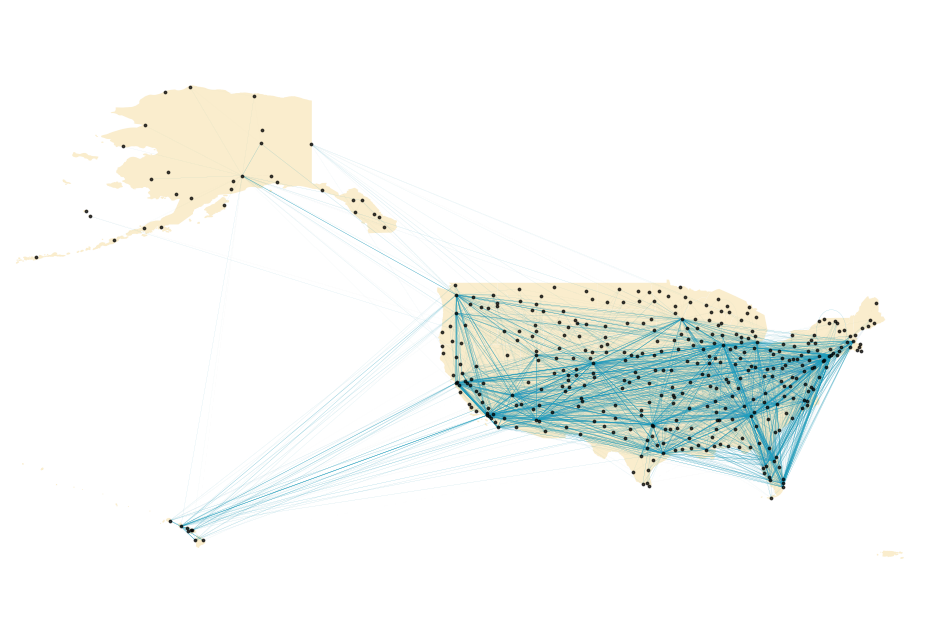

In [41]:
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

fig,ax = plt.subplots(figsize=(12,8))

us.plot(ax=ax,facecolor='#faedcd')
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=3,
                       node_color='black',
                       alpha=0.7);
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=np.array(list(widths.values()))/80000,
                       edge_color='#219ebc',
                       alpha=1,arrows=False);

ax.set_ylim(10,80)
ax.set_xlim(-180,-60)
plt.axis('off')

### draw network with effective length between airports

In [42]:
G = nx.DiGraph()
G.add_nodes_from(airports)
for row in OD_matrix.iterrows():
    i = (row[1].OrigCity)
    d = (row[1].DestCity)
    flow = (row[1].effective_length)
    G.add_edge(i,d,weight=flow)

(-180.0, -60.0, 10.0, 80.0)

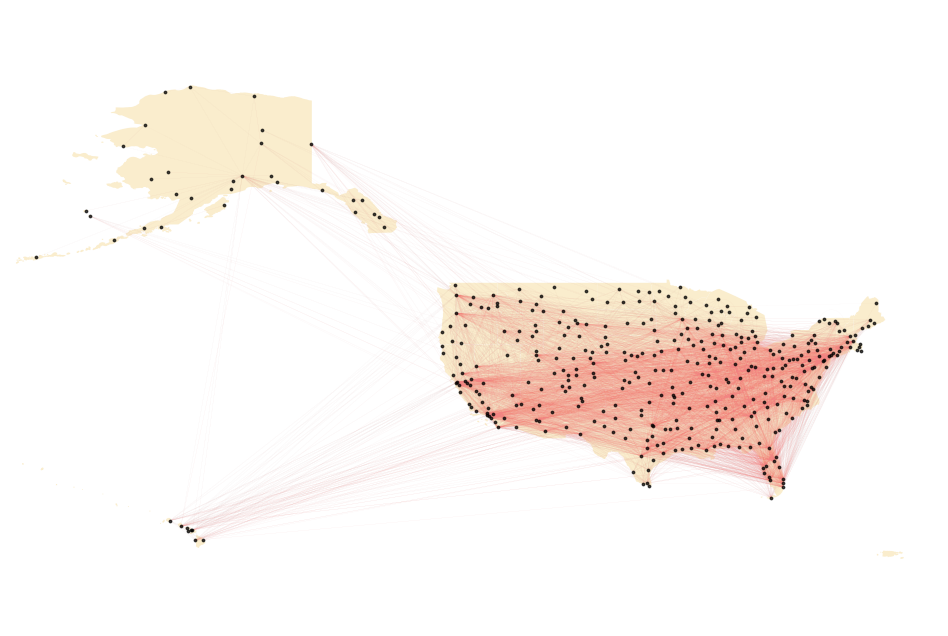

In [43]:
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

fig,ax = plt.subplots(figsize=(12,8))

us.plot(ax=ax,facecolor='#faedcd')
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=3,
                       node_color='black',
                       alpha=0.7);
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=np.fromiter(widths.values(), dtype=float)/500,
                       edge_color='#f28482',
                       alpha=1,arrows=False);

ax.set_ylim(10,80)
ax.set_xlim(-180,-60)
plt.axis('off')

### find effective distance from given epidemic source

In [44]:
from networkx.algorithms.shortest_paths.generic import shortest_path
#from networkx.classes.function import path_weight

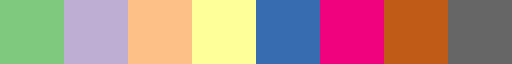

In [45]:
cmap = cm.Accent
cmap

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_22050/3077977898.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,shrink=0.4,label='arrival time',pad=-.01)


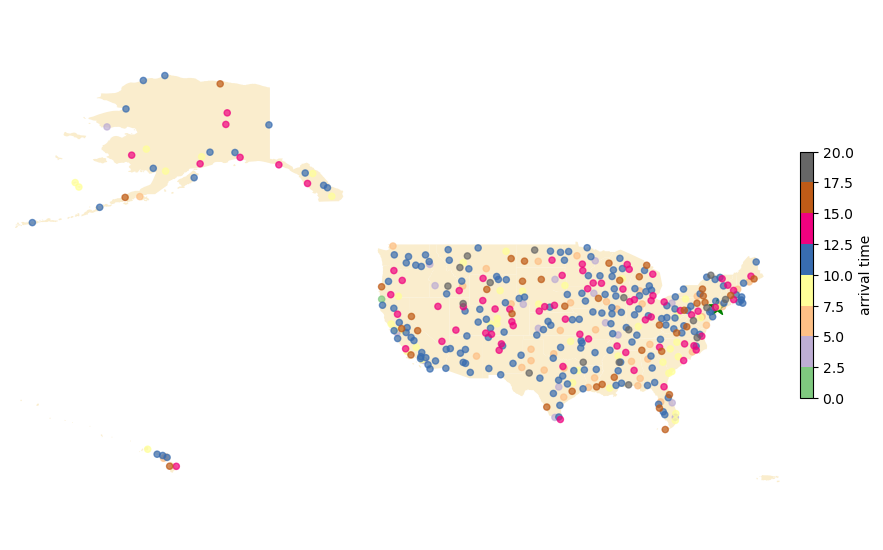

In [186]:
#decide the source of the epidemic
source_1 = 'New York'

#compute arrival times with the effective distance
arrival_times_1 = nx.shortest_path_length(G,source=source_1,weight='weight')
arrival_times_1

G_at = nx.DiGraph()
G_at.add_nodes_from(airports)
nodelist_at = G_at.nodes()
cmap = cm.Accent
max_at = 20 #max(arrival_times.values())

fig,ax = plt.subplots(figsize=(12,8))

us.plot(ax=ax,facecolor='#faedcd')
nx.draw_networkx_nodes(G_at,pos,
                       nodelist=nodelist_at,
                       node_size=20,
                       node_color=cmap(np.fromiter(arrival_times_1.values(), dtype=float)/max_at),
                       alpha=0.7);

ax.scatter(pos[source_1][0],pos[source_1][1],marker='*',s=150,color='green')

ax.set_ylim(10,80)
ax.set_xlim(-180,-60)
plt.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=max_at))
plt.colorbar(sm,shrink=0.4,label='arrival time',pad=-.01)

## travel bans  
create new column with new flows cut by 50% from source to all destinations  
recompute effective length  
see difference in arrival times

In [213]:
ban_fraction = 0.9
OD_matrix['fraction_passengers_with_ban'] = OD_matrix[['Passengers','outPassengers','OrigCity']].apply(lambda x: x[0]*(1-ban_fraction)/x[1] if x[2]==source_1 else x[0]/x[1], axis=1)
OD_matrix['effective_length_with_ban'] = OD_matrix['fraction_passengers_with_ban'].apply(lambda x: 1-np.log(x))


In [214]:

G2 = nx.DiGraph()
G2.add_nodes_from(airports)
for row in OD_matrix.iterrows():
    i = (row[1].OrigCity)
    d = (row[1].DestCity)
    flow = (row[1].effective_length_with_ban)
    G2.add_edge(i,d,weight=flow)

/var/folders/q5/29y9rnzj2_3f5fwgkltpph4h0000gn/T/ipykernel_22050/763112127.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,shrink=0.4,label='arrival time',pad=-.01)


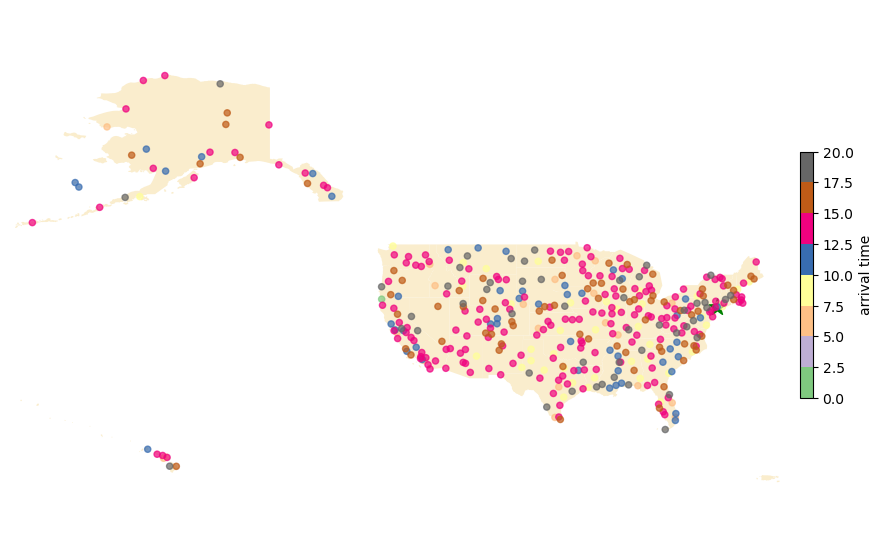

In [215]:
#decide the source of the epidemic

#compute arrival times with the effective distance
arrival_times_2 = nx.shortest_path_length(G2,source=source_1,weight='weight')

G_at = nx.DiGraph()
G_at.add_nodes_from(airports)
nodelist_at = G_at.nodes()

fig,ax = plt.subplots(figsize=(12,8))

us.plot(ax=ax,facecolor='#faedcd')
nx.draw_networkx_nodes(G_at,pos,
                       nodelist=nodelist_at,
                       node_size=20,
                       node_color=cmap(np.fromiter(arrival_times_2.values(), dtype=float)/max_at),
                       alpha=0.7);

ax.scatter(pos[source_1][0],pos[source_1][1],marker='*',s=150,color='green')

ax.set_ylim(10,80)
ax.set_xlim(-180,-60)
plt.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=max_at))
plt.colorbar(sm,shrink=0.4,label='arrival time',pad=-.01)

Text(0, 0.5, 'arrival times with travel bans')

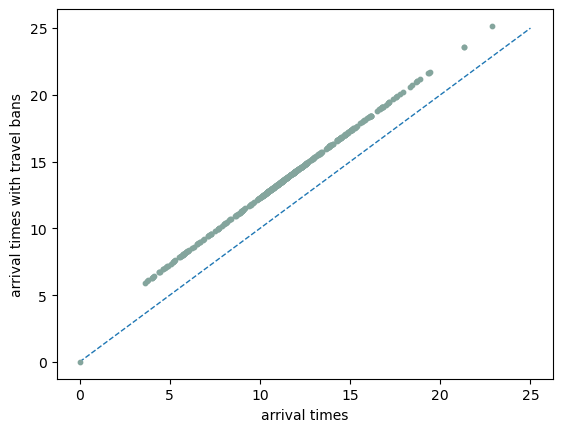

In [216]:
fig,ax=plt.subplots()
ax.plot([0,25],[0,25],lw=1,ls='--',zorder=0);
at1 = dict(sorted(arrival_times_1.items()))
at2 = dict(sorted(arrival_times_2.items()))
ax.scatter(at1.values(),at2.values(),s=10,color='#84a59d',zorder=1);

plt.xlabel('arrival times')
plt.ylabel('arrival times with travel bans')

### plot difference in arrival times with banned fraction of trips from the source  
what was the delay in arrival times with flows cut by w  
From Gautreau et al:  
$\Large \langle t_{arr,TR} \rangle - \langle t_{arrival} \rangle \simeq  -log (w) $ 

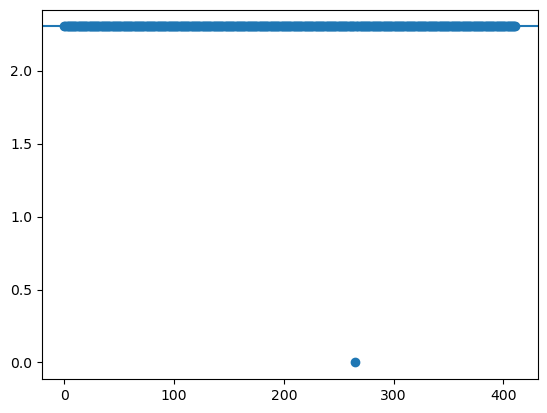

In [217]:
plt.scatter(np.arange(len(at1)),np.array(list(at2.values())) - np.array(list(at1.values())))
w = ban_fraction
plt.axhline(-np.log(1-w))

### now try placing the source in another airport and see the differences in arrival times  
1) try peripheral vs central nodes  
2) east coast vs west coast  
3) islands